## Часть 3. Выбор и обоснование финальной регрессионной модели

Для прогнозирования цены акции ПАО «Татнефть» в качестве основной рассматривалась модель Temporal Fusion Transformer (TFT), так как она сочетает высокую точность с возможностью интерпретации результатов за счёт attention-механизмов и отбора признаков, эффективно работает с разнородными данными и подходит для многогоризонтного прогнозирования. В исследовании на криптовалютном рынке показано, что TFT даёт более точные прогнозы, чем LSTM, GRU, SVR и XGBoost, а также позволяет понять, какие признаки оказывают наибольшее влияние на результат прогноза (исследование: mdpi.com).

Для подтверждения целесообразности использования TFT был проведён ряд экспериментов с применением как классических моделей машинного обучения (CatBoost, XGBoost), так и глубоких нейронных сетей (CNN, GRU, LSTM).

Наилучшие результаты показала модель TFT, которая по всем основным метрикам (RMSE, MAE, MAPE) превзошла конкурентов, что отражено в сводной таблице метрик ниже.

Почему именно TFT стала финальным выбором:

1. Высокое качество прогноза — минимальные ошибки RMSE, MAE и MAPE среди всех протестированных моделей.
2. Гибкость работы с временными рядами — учёт как долгосрочных, так и краткосрочных зависимостей за счёт сочетания рекуррентных и attention-механизмов.
3. Стабильность — устойчивые и воспроизводимые результаты на тестовой выборке без значительного падения качества.

| Модель    | RMSE       | MAE        | MAPE    |
|-----------|-----------:|-----------:|--------:|
| CatBoost  | 149.4578   | 131.6093   | 21.95%  |
| XGBoost   | 185.7881   | 170.6799   | 30.34%  |
| CNN       | 43.2257    | 33.3976    | 5.82%   |
| GRU       | 130.1248   | 105.2222   | 21.50%  |
| LSTM      | 99.4183    | 84.8469    | 16.40%  |
| TFT       | **22.3654**| **18.2451**| **2.63%** |

Таким образом, TFT была выбрана в качестве финальной регрессионной модели, так как на данных с историей цен, техническими индикаторами, макроэкономическими параметрами и текстовыми эмбеддингами она показала наилучший баланс между точностью прогноза, интерпретируемостью и возможностью интеграции в аналитический пайплайн.

#### Блок 1. Импорты и регрессионная метрика

In [17]:
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from torchmetrics.regression import MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE, convert_torchmetric_to_pytorch_forecasting_metric
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# Фиксация seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Лосс и метрика
loss = RMSE()
metric = convert_torchmetric_to_pytorch_forecasting_metric(MeanAbsoluteError())


#### Блок 2: Подготовка данных для регрессионных моделей

В данном блоке кода мы обрабатываем ДФ, полученный в Части 1 (Сбор и обработка данных), чтобы адаптировать его под требования модели TFT для решения задачи регрессии, т. е. прогнозирования цены акции ПАО «Татнефть» через 5 торговых дней. Подготовка включает приведение структуры данных к удобному формату, генерацию целевой переменной и масштабирование только части признаков, что необходимо для корректного и стабильного обучения TFT.

Мы масштабируем только признаки, используемые в качестве входных данных модели, исключая признаки *date* и целевую переменную *target_5d*. Такой подход позволяет сохранить корректный временной индекс и интерпретируемость прогнозируемых значений, при этом обеспечивая единый масштаб входных данных.

В данном блоке выполняются следующие операции:

1. Загрузка и сортировка данных — читаем ДФ из файла CSV, преобразуем столбец с датой в формат *datetime* и сортируем строки по возрастанию даты для сохранения хронологического порядка.
2. Очистка названий признаков — заменяем символы `.` и `%` на `_`, чтобы избежать ошибок при работе с именами признаков в коде и при сохранении данных.
3. Генерация целевой переменной — создаём колонку *target_5d*, смещая цены на 5 торговых дней вперёд, чтобы каждая строка содержала прогнозируемое значение на этот горизонт.
4. Удаление неполных данных — исключаем последние 5 строк, для которых целевая переменная не может быть рассчитана.
5. Масштабирование признаков — нормализуем все числовые признаки, кроме *date* и *target_5d*, с помощью `StandardScaler`, чтобы улучшить сходимость и устойчивость обучения TFT.
6. Объединение данных — собираем в единый ДФ немасштабированные столбцы *date* и *target_5d* с масштабированными входными признаками.
7. Сохранение результата — записываем готовый ДФ в отдельный CSV-файл для дальнейшего обучения и тестирования модели.

В результате мы получаем чистый, частично нормализованный и полностью готовый к использованию набор данных, где каждая строка содержит дату, масштабированные входные признаки и немасштабированное целевое значение, соответствующее прогнозу цены акции через 5 торговых дней.

In [21]:
# Пути
input_path = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_1\котировки_с_rubert.csv"
output_path = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\tatn_weekly_REG.csv"

# Загрузка данных
df = pd.read_csv(input_path, parse_dates = ['date'])
df = df.sort_values('date').reset_index(drop = True)

# Очистка названий колонок: заменим '.' и '%' на '_'
df.columns = [col.replace('.', '_').replace('%', '_') for col in df.columns]

# Генерация таргета: цена через 5 торговых дней
df['target_5d'] = df['price'].shift(-5)

# Удаляем строки без target_5d (последние 5 дней)
df = df.dropna(subset = ['target_5d']).reset_index(drop = True)

# Масштабирование признаков (кроме даты и таргета)
exclude_cols = ['date', 'target_5d']
features = [col for col in df.columns if col not in exclude_cols]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns = features)

# Объединяем с немасштабированными колонками
df_final = pd.concat([df[['date']], df_scaled, df[['target_5d']]], axis=1)

# Сохраняем
df_final.to_csv(output_path, index = False)
print(f"Файл сохранён: {output_path}")

df_final.head()

Файл сохранён: C:\Users\Администратор\Desktop\Аналитик данных\Дипломная работа\DL\Регрессия\tatn_weekly_REG.csv


,date,price,open,high,low,vol_,change _,ema_5,ema_14,ema_50,...,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767,target_5d
0,2012-01-03,-1.440906,-1.509459,-1.454655,-1.491959,-0.169129,3.290823,-1.448168,-1.455289,-1.457287,...,0.737285,1.077516,-0.986154,1.129628,-0.276002,-0.594158,-1.090323,-0.709935,-0.683390,174.00
1,2012-01-04,-1.432701,-1.432396,-1.448788,-1.437763,-0.042672,0.391525,-1.449738,-1.455588,-1.456169,...,0.737285,1.077516,-0.986154,1.129628,-0.276002,-0.594158,-1.090323,-0.709935,-0.683390,169.61
2,2012-01-05,-1.456330,-1.434421,-1.443177,-1.443691,-0.290316,-1.232449,-1.456203,-1.457202,-1.455346,...,0.308069,0.626133,1.584770,-0.216623,1.447056,3.093518,0.220764,-2.202539,1.816620,168.50
3,2012-01-06,-1.453007,-1.450260,-1.460060,-1.444583,-0.766941,0.143800,-1.454065,-1.455410,-1.453507,...,0.236097,0.328905,1.561778,-0.222538,1.401898,2.844294,-0.039920,-2.271590,1.967388,167.50
4,2012-01-09,-1.449631,-1.452077,-1.453420,-1.439022,-0.760344,0.143800,-1.452522,-1.453857,-1.451732,...,0.737285,1.077516,-0.986154,1.129628,-0.276002,-0.594158,-1.090323,-0.709935,-0.683390,168.01


#### Блок 3: Формирование финального ДФ с календарными и служебными признаками для TFT

В данном блоке кода мы подготавливаем окончательный набор данных, в котором к уже обработанным признакам из предыдущего шага добавляем календарные и служебные колонки, необходимые для корректной работы модели TFT. Этот этап важен, так как TFT умеет учитывать временные закономерности и категориальные признаки, а также требует определённой структуры входных данных.

В данном блоке мы выполняем следующие операции:

1. Загрузка и сортировка данных — читаем ДФ, полученный на предыдущем этапе подготовки, и сортируем его по дате, чтобы сохранить хронологический порядок наблюдений.
2. Генерация календарных признаков — добавляем новые колонки, отражающие временные характеристики каждой записи:  
   2.1. time_idx — числовой индекс времени, необходимый TFT для построения временной оси;  
   2.2. year, quarter, month, day, day_of_week — разбиение даты на компоненты для учёта сезонности и повторяющихся паттернов;  
   2.3. is_weekend — индикатор выходных дней (суббота, воскресенье);  
   2.4. is_month_start, is_month_end — индикаторы начала и конца месяца;  
   2.5. day_of_year — порядковый номер дня в году, полезен для выявления годовой сезонности.  
3. Преобразование категориальных признаков в строки — переводим month, day_of_week, is_weekend в строковый формат, а также задаём фиксированный идентификатор временного ряда group_id = "tatneft". Это важно, так как TFT требует явного разделения категориальных и числовых признаков.
4. Финальная перестановка колонок — формируем итоговый порядок: сначала служебные поля (group_id, time_idx, date), затем признаки, и в конце целевая переменная target_5d.
5. Сохранение итогового ДФ — записываем полученные данные в отдельный CSV-файл, который уже готов к загрузке в TimeSeriesDataSet библиотеки pytorch-forecasting.

В результате мы получаем структурированный ДФ, полностью соответствующий входным требованиям TFT: с выделенным идентификатором временного ряда, индексом времени, календарными признаками и целевой переменной для прогноза цены акции через 5 торговых дней.


In [19]:
# Пути
input_path = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\tatn_weekly_REG.csv"
output_path = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\tatn_tft_weekly_REG.csv"

# Загрузка и сортировка
df = pd.read_csv(input_path, parse_dates = ['date'])
df = df.sort_values('date').reset_index(drop = True)

# Календарные признаки
df['time_idx'] = df.index
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.weekday
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['day_of_year'] = df['date'].dt.dayofyear

# Преобразование категориальных признаков в строки (важно для TFT)
df['group_id'] = 'tatneft'                         # как строка
df['month'] = df['month'].astype(str)
df['day_of_week'] = df['day_of_week'].astype(str)
df['is_weekend'] = df['is_weekend'].astype(str)

# Финальный порядок столбцов
reserved = ['group_id', 'time_idx', 'date', 'target_5d']
feature_cols = [col for col in df.columns if col not in reserved]
df_tft = df[['group_id', 'time_idx', 'date'] + feature_cols + ['target_5d']]

# Сохранение
df_tft.to_csv(output_path, index = False)
print(f"Данные для TFT сохранены: {output_path}")

df_tft.head()

Данные для TFT сохранены: C:\Users\Администратор\Desktop\Аналитик данных\Дипломная работа\DL\Регрессия\tatn_tft_weekly_REG.csv


,group_id,time_idx,date,price,open,high,low,vol_,change _,ema_5,...,year,quarter,month,day,day_of_week,is_weekend,is_month_start,is_month_end,day_of_year,target_5d
0,tatneft,0,2012-01-03,-1.440906,-1.509459,-1.454655,-1.491959,-0.169129,3.290823,-1.448168,...,2012,1,1,3,1,0,0,0,3,174.00
1,tatneft,1,2012-01-04,-1.432701,-1.432396,-1.448788,-1.437763,-0.042672,0.391525,-1.449738,...,2012,1,1,4,2,0,0,0,4,169.61
2,tatneft,2,2012-01-05,-1.456330,-1.434421,-1.443177,-1.443691,-0.290316,-1.232449,-1.456203,...,2012,1,1,5,3,0,0,0,5,168.50
3,tatneft,3,2012-01-06,-1.453007,-1.450260,-1.460060,-1.444583,-0.766941,0.143800,-1.454065,...,2012,1,1,6,4,0,0,0,6,167.50
4,tatneft,4,2012-01-09,-1.449631,-1.452077,-1.453420,-1.439022,-0.760344,0.143800,-1.452522,...,2012,1,1,9,0,0,0,0,9,168.01


#### Блок 4. Загрузка и проверка финального ДФ для TFT

В данном блоке кода мы загружаем подготовленный на предыдущем этапе финальный ДФ, который уже содержит все необходимые признаки для обучения модели TFT. На этом шаге мы также задаём правильные форматы данных для ключевых признаков и проводим базовую проверку структуры.

В данном блоке выполняются следующие операции:

1. Определение пути к файлу — указываем расположение CSV-файла `tatn_tft_weekly_REG.csv`, сформированного на предыдущем шаге.
2. Загрузка данных с контролем типов — читаем файл с помощью `pandas.read_csv`, при этом:  
   2.1. преобразуем колонку `date` в формат `datetime`, чтобы сохранить возможность работы с календарными функциями;  
   2.2. принудительно задаём строковый (`str`) тип для категориальных признаков `group_id`, `month`, `day_of_week` и `is_weekend`. Это важно, чтобы при обучении TFT они были корректно распознаны как категориальные, а не числовые.
3. Сортировка по дате — упорядочиваем строки в хронологическом порядке для сохранения правильной временной последовательности.
4. Базовая проверка загруженных данных — выводим размер ДФ (количество строк и колонок), чтобы убедиться в корректности загрузки и отсутствии ошибок при чтении.

В результате мы получаем корректно загруженный и структурированный набор данных, полностью готовый к созданию объекта `TimeSeriesDataSet` для дальнейшего обучения модели TFT.

In [2]:
# Пути
input_path = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\tatn_tft_weekly_REG.csv"

# Загрузка и проверка
df = pd.read_csv(
    input_path, parse_dates = ["date"],
    dtype = {
        "group_id": str,
        "month": str,
        "day_of_week": str,
        "is_weekend": str
    }
)
df = df.sort_values("date").reset_index(drop = True)
print("Данные загружены:", df.shape)


Данные загружены: (3357, 925)


#### Блок 5. Определение параметров и разбиение данных для обучения TFT

В данном блоке кода мы задаём ключевые параметры обучения модели TFT, определяем структуру признаков и выполняем разбиение данных на обучающую и валидационную выборки. Эти шаги критически важны, так как TFT требует чёткого разделения признаков по типам (статические, временные известные, временные неизвестные) и корректного формирования временных интервалов для обучения.

В данном блоке мы выполняем следующие операции:

1. Задание основных параметров для конструктора:  
   1.1. target — название колонки с целевой переменной (*target_5d*), которую модель должна предсказать;  
   1.2. time_idx — колонка с числовым индексом времени, используемая для построения временной шкалы;  
   1.3. group_id — идентификатор временного ряда (в нашем случае один ряд — акции ПАО «Татнефть»);  
   1.4. max_encoder_length — длина исторического окна (в днях), используемого для обучения модели;  
   1.5. max_prediction_length — горизонт прогноза (в нашем случае 1 шаг = 5 торговых дней вперёд);  
   1.6. batch_size — размер мини-батча для обучения.  
2. Разделение признаков по типам в соответствии с требованиями TFT:  
   2.1. Статические категориальные (*static_categoricals*) — признаки, значения которых не меняются во времени (здесь только *group_id*);  
   2.2. Временные категориальные, известные заранее (*time_varying_known_categoricals*) — календарные признаки (*month*, *day_of_week*, *is_weekend*), которые можно определить для любой даты ещё до начала прогноза;  
   2.3. Временные числовые, известные заранее (*time_varying_known_reals*) — числовые признаки, которые также известны на любом горизонте (*time_idx*, *day_of_year*);  
   2.4. Временные числовые, неизвестные заранее (*time_varying_unknown_reals*) — все прочие числовые признаки, значения которых будут известны только в момент прогноза (рыночные, макроэкономические, технические).  
3. Разбиение данных на *train* и *validation*:  
   3.1. Отбираем только данные до 2025 года для обучения (*df_trainval*), чтобы тестировать модель на будущем периоде;  
   3.2. Делим оставшиеся данные в пропорции 80 % на обучение (*train_df*) и 20 % на валидацию (*val_df*), сохраняя хронологический порядок.

В результате мы получаем чётко структурированные обучающие и валидационные выборки с разделением признаков по типам, полностью готовые к созданию объекта `TimeSeriesDataSet` для обучения TFT.

In [3]:
# Настройки
target = "target_5d"
time_idx = "time_idx"
group_id = "group_id"
max_encoder_length = 90
max_prediction_length = 1
batch_size = 32

# Категориальные и непрерывные признаки
static_categoricals = ["group_id"]
time_varying_known_categoricals = ["month", "day_of_week", "is_weekend"]
time_varying_known_reals = ["time_idx", "day_of_year"]
time_varying_unknown_reals = [
    col for col in df.columns if col not in [
        "group_id", "time_idx", "date", target,
        "month", "day_of_week", "is_weekend", "day_of_year"
    ]
]

# Сплит на train/val по дате
df_trainval = df[df["date"] < "2025-01-01"].reset_index(drop = True)  # обучаем только на данных до 2025
split_idx = int(len(df_trainval) * 0.8)
train_df = df_trainval.iloc[:split_idx].reset_index(drop = True)
val_df = df_trainval.iloc[split_idx:].reset_index(drop = True)


#### Блок 6. Формирование объектов TimeSeriesDataSet и DataLoader для TFT

В данном блоке кода мы подготавливаем данные в специальном формате `TimeSeriesDataSet`, который используется библиотекой `pytorch-forecasting` для обучения модели TFT. Этот формат позволяет модели корректно обрабатывать временные ряды, автоматически управлять лагами, признаками и разметкой обучающих примеров.

В данном блоке мы проводим следующие операции:

1. Создание обучающего набора (*training*) — передаём ДФ с тренировочными данными и указываем:  
   1.1. `time_idx` — числовой индекс времени, определяющий порядок наблюдений;  
   1.2. `target` — целевая переменная (*target_5d*), которую нужно предсказать;  
   1.3. `group_ids` — идентификаторы временных рядов (в нашем случае один ряд — акции ПАО «Татнефть»);  
   1.4. `max_encoder_length` — длина истории (в днях), которую модель видит перед прогнозом;  
   1.5. `max_prediction_length` — длина горизонта прогноза (у нас 1 точка — цена через 5 торговых дней);  
   1.6. `static_categoricals`, `time_varying_known_categoricals`, `time_varying_known_reals`, `time_varying_unknown_reals` — распределение признаков по типам (статические, известные заранее и неизвестные);  
   1.7. `target_normalizer` — нормализация целевой переменной в разрезе каждого временного ряда;  
   1.8. `add_relative_time_idx`, `add_target_scales`, `add_encoder_length` — добавление вспомогательных признаков для улучшения обучения;  
   1.9. `allow_missing_timesteps=True` — разрешение пропусков дат в ряде (полезно при неполных данных).  
2. Создание валидационного набора (*validation*) — формируем его с помощью метода `.from_dataset()`, чтобы сохранить те же параметры признаков и нормализации, что и у обучающего набора, но применить к валидационным данным.
3. Создание DataLoader’ов — конвертируем оба набора в DataLoader, который управляет пакетной подачей данных в модель во время обучения и валидации. Здесь указываем `batch_size` и количество потоков для ускорения загрузки.

В результате мы получаем готовые объекты *training*, *validation*, *train_loader* и *val_loader*, которые можно напрямую передавать в модель TFT для обучения и проверки качества прогноза.


In [4]:
# TimeSeriesDataSet
training = TimeSeriesDataSet(
    train_df,
    time_idx = time_idx,
    target = target,
    group_ids = [group_id],
    max_encoder_length = max_encoder_length,
    max_prediction_length = max_prediction_length,
    static_categoricals = static_categoricals,
    time_varying_known_categoricals = time_varying_known_categoricals,
    time_varying_known_reals = time_varying_known_reals,
    time_varying_unknown_reals = time_varying_unknown_reals,
    target_normalizer = GroupNormalizer(groups = [group_id], transformation = "softplus"),  
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
    allow_missing_timesteps = True,
)

# Валидация
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict = True, stop_randomization = True)

# DataLoader’ы
train_loader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 4, persistent_workers = True)
val_loader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 4, persistent_workers = True)

print("TimeSeriesDataSet и DataLoader’ы готовы")


TimeSeriesDataSet и DataLoader’ы готовы


#### Блок 7. Инициализация и обучение TFT

В данном блоке кода мы создаём и обучаем модель TFT на подготовленных `TimeSeriesDataSet`. Здесь задаются ключевые гиперпараметры архитектуры, метрики, колбэки ранней остановки и сохранения лучшей версии модели, а также конфигурация тренера.

В данном блоке мы проводим следующие операции:

1. Создание модели из датасета `TemporalFusionTransformer.from_dataset` автоматически подтягивает размеры и типы признаков из *training*:  
   1.1. `learning_rate = 2e-3` — стартовая скорость обучения.  
   1.2. `hidden_size = 128` — ширина скрытых слоёв (ёмкость модели).  
   1.3. `attention_head_size = 2` — число «голов» в механизме внимания.  
   1.4. `hidden_continuous_size = 64` — размерность проекций для непрерывных признаков.  
   1.5. `dropout = 0.05` — регуляризация для борьбы с переобучением.  
   1.6. `reduce_on_plateau_patience = 4` — уменьшение *learning rate* при застое качества.  
   1.7. `loss = RMSE()` — функция потерь: корень из MSE по таргету *target_5d*.  
   1.8. `logging_metrics = [metric]` — дополнительная метрика в логах (например, MAE).  
   1.9. `output_size = 1` — скалярный прогноз (цена через 5 дней).  
2. Колбэки контроля обучения:  
   2.1. `EarlyStopping(monitor="val_loss", patience=5, mode="min")` — останавливаем обучение, если валидационная ошибка не улучшается 5 эпох.  
   2.2. `ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")` — сохраняем лучшую версию модели по *val_loss* в указанную папку.  
   2.3. `TQDMProgressBar(refresh_rate=20)` — прогресс-бар для наглядного контроля процесса.  
3. Конфигурация тренера и запуск обучения:  
   3.1. `max_epochs = 50` — верхний предел числа эпох.  
   3.2. `accelerator = "gpu" if torch.cuda.is_available() else "cpu"` — автоматический выбор устройства.  
   3.3. `devices = 1` — одна видеокарта или процессор.  
   3.4. `gradient_clip_val = 0.1` — клиппинг градиента для устойчивости.  
   3.5. `callbacks = [early_stop, checkpoint, progress_bar]` — подключаем контроль качества и сохранение.  
   3.6. `trainer.fit(tft, train_loader, val_loader)` — непосредственный запуск обучения на батчах.

В результате модель TFT обучается с контролем переобучения и автоматическим сохранением лучшей версии по *val_loss*. После завершения на диске сохраняется чекпойнт, готовый к использованию для валидации, теста и прогнозов.


In [5]:
# Модель TFT
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 2e-3,
    hidden_size = 128,
    attention_head_size = 2,
    hidden_continuous_size = 64,
    dropout = 0.05,
    reduce_on_plateau_patience = 4,
    log_interval = 10,
    loss = RMSE(),
    logging_metrics = [metric],
    output_size = 1,
)

# Колбэки
early_stop = EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
checkpoint = ModelCheckpoint(
    dirpath = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\TFT",
    filename = "tft_model_target_5d",
    monitor = "val_loss",
    save_top_k = 1,
    mode = "min"
)

progress_bar = TQDMProgressBar(refresh_rate = 20)

# Обучение
trainer = Trainer(
    max_epochs = 50,
    accelerator = "gpu" if torch.cuda.is_available() else "cpu",
    devices = 1,
    gradient_clip_val = 0.1,
    callbacks=[early_stop, checkpoint, progress_bar]
)

trainer.fit(tft, train_loader, val_loader)
print("Обучение завершено")


C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Users\Администратор\Desktop\Аналитик данных\Дипломн

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Обучение завершено


#### Блок 8. Скользящее тестирование обученной TFT и оценка качества прогноза

В данном блоке кода мы загружаем обученную модель TFT из чекпойнта, формируем шаблон `TimeSeriesDataSet` для предсказания и выполняем скользящее прогнозирование по окну фиксированной длины. Далее считаем метрики качества, строим наглядные графики и собираем финальный ДФ с результатами для анализа.

В данном блоке мы проводим следующие операции:

1. Задаём ключевые параметры прогноза: длину исторического окна `encoder_length = 90`, размер батча для предсказаний, имя целевой переменной `target_5d`, дату старта окна и пути к данным и чекпойнту модели.
2. Читаем подготовленный CSV с признаками для TFT и загружаем обученную модель из файла `tft_model_target_5d.ckpt`.
3. Явно переводим колонки `group_id`, `month`, `day_of_week`, `is_weekend` в строковый тип, чтобы при прогнозе они корректно обрабатывались как категориальные.
4. На основе полного ДФ формируем базовый `TimeSeriesDataSet`, где задаём роли признаков: статические категориальные, временные известные заранее, временные неизвестные, а также нормализацию таргета `GroupNormalizer`. Этот шаблон далее используем для быстрой сборки датасетов на каждом шаге скользящего окна.
5. Фильтруем данные, начиная с `start_date`, чтобы сформировать последовательность для пошагового прогноза.
6. Для каждого шага берём последние 90 наблюдений как энкодер и текущую точку как декодер:  
   6.1. создаём датасет через `TimeSeriesDataSet.from_dataset` с теми же настройками, что у шаблона;  
   6.2. строим DataLoader и получаем прогноз модели;  
   6.3. сохраняем прогноз `pred`, фактическое значение `true` (цена через 5 торговых дней), последнюю известную цену `last_price` и дату прогноза.  
   Дополнительно отсеиваем прогнозы до 2025 года, чтобы тестировать только на будущем периоде.
7. Считаем **MAE**, **RMSE**, **MAPE** по собранным массивах фактов и прогнозов, чтобы количественно оценить качество модели на реальном форвардном прогоне.
8. Строим гистограмму относительных ошибок и график «факт vs прогноз» по датам, чтобы увидеть динамику и характер ошибок (сдвиги, сглаживание пиков, возможные всплески).
9. Формируем `df_results` с датой, фактом, прогнозом, последней известной ценой до прогноза, абсолютной/относительной ошибками и смещением прогноза. Это удобная основа для последующего анализа, экспорта и включения в отчёт.

C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Админи

2025-02-11 | Прогноз: 710.07 | Факт: 737.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-12 | Прогноз: 725.20 | Факт: 744.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-13 | Прогноз: 734.96 | Факт: 745.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-14 | Прогноз: 731.60 | Факт: 754.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-17 | Прогноз: 733.03 | Факт: 752.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-18 | Прогноз: 741.51 | Факт: 764.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-19 | Прогноз: 746.66 | Факт: 737.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-20 | Прогноз: 749.07 | Факт: 713.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-21 | Прогноз: 749.11 | Факт: 732.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-24 | Прогноз: 743.45 | Факт: 711.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-25 | Прогноз: 738.66 | Факт: 714.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-26 | Прогноз: 740.40 | Факт: 705.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-27 | Прогноз: 726.53 | Факт: 700.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-02-28 | Прогноз: 718.31 | Факт: 693.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-03 | Прогноз: 709.15 | Факт: 683.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-04 | Прогноз: 699.13 | Факт: 694.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-05 | Прогноз: 703.79 | Факт: 694.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-06 | Прогноз: 699.66 | Факт: 710.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-07 | Прогноз: 694.34 | Факт: 715.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-10 | Прогноз: 685.17 | Факт: 714.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-11 | Прогноз: 685.20 | Факт: 705.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-12 | Прогноз: 698.97 | Факт: 699.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-13 | Прогноз: 704.05 | Факт: 688.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-14 | Прогноз: 707.19 | Факт: 693.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-17 | Прогноз: 699.58 | Факт: 686.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-18 | Прогноз: 694.02 | Факт: 697.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-19 | Прогноз: 694.22 | Факт: 684.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-20 | Прогноз: 690.89 | Факт: 675.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-21 | Прогноз: 684.08 | Факт: 687.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-24 | Прогноз: 676.76 | Факт: 673.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-25 | Прогноз: 672.10 | Факт: 653.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-26 | Прогноз: 677.80 | Факт: 673.20


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-27 | Прогноз: 670.41 | Факт: 649.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-28 | Прогноз: 662.91 | Факт: 618.20


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-03-31 | Прогноз: 653.12 | Факт: 636.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-01 | Прогноз: 648.47 | Факт: 621.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-02 | Прогноз: 644.45 | Факт: 638.20


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-03 | Прогноз: 644.92 | Факт: 655.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-04 | Прогноз: 630.54 | Факт: 686.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-07 | Прогноз: 622.74 | Факт: 686.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-08 | Прогноз: 631.91 | Факт: 684.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-09 | Прогноз: 641.68 | Факт: 685.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-10 | Прогноз: 661.05 | Факт: 694.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-11 | Прогноз: 676.63 | Факт: 693.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-14 | Прогноз: 687.08 | Факт: 706.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-15 | Прогноз: 687.07 | Факт: 703.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-16 | Прогноз: 694.23 | Факт: 693.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-17 | Прогноз: 698.94 | Факт: 690.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-18 | Прогноз: 702.36 | Факт: 719.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-21 | Прогноз: 701.95 | Факт: 725.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-22 | Прогноз: 704.81 | Факт: 723.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-23 | Прогноз: 708.69 | Факт: 714.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-24 | Прогноз: 708.89 | Факт: 698.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-25 | Прогноз: 712.39 | Факт: 680.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-28 | Прогноз: 718.71 | Факт: 685.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-29 | Прогноз: 715.58 | Факт: 691.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-04-30 | Прогноз: 714.44 | Факт: 696.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-02 | Прогноз: 707.56 | Факт: 720.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-05 | Прогноз: 693.92 | Факт: 715.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-06 | Прогноз: 689.30 | Факт: 700.50


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-07 | Прогноз: 700.14 | Факт: 695.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-08 | Прогноз: 709.65 | Факт: 699.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-12 | Прогноз: 708.07 | Факт: 706.30


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-13 | Прогноз: 712.07 | Факт: 709.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-14 | Прогноз: 710.97 | Факт: 703.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-15 | Прогноз: 708.22 | Факт: 690.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-16 | Прогноз: 705.82 | Факт: 691.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-17 | Прогноз: 691.84 | Факт: 692.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-18 | Прогноз: 695.48 | Факт: 690.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-19 | Прогноз: 700.79 | Факт: 678.60


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-20 | Прогноз: 693.50 | Факт: 680.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-21 | Прогноз: 692.26 | Факт: 685.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-22 | Прогноз: 694.47 | Факт: 687.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-23 | Прогноз: 690.58 | Факт: 704.80


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


2025-05-26 | Прогноз: 681.12 | Факт: 656.50
Оценка модели по таргету: target_5d
MAE:   18.2451
RMSE:  22.3654
MAPE:  2.63%
R2:    0.3345


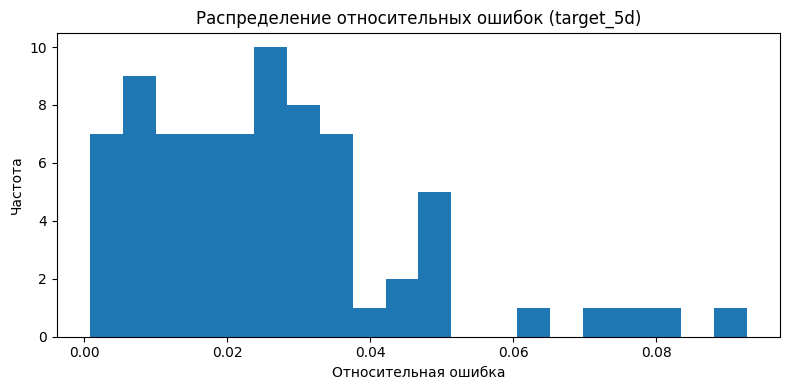

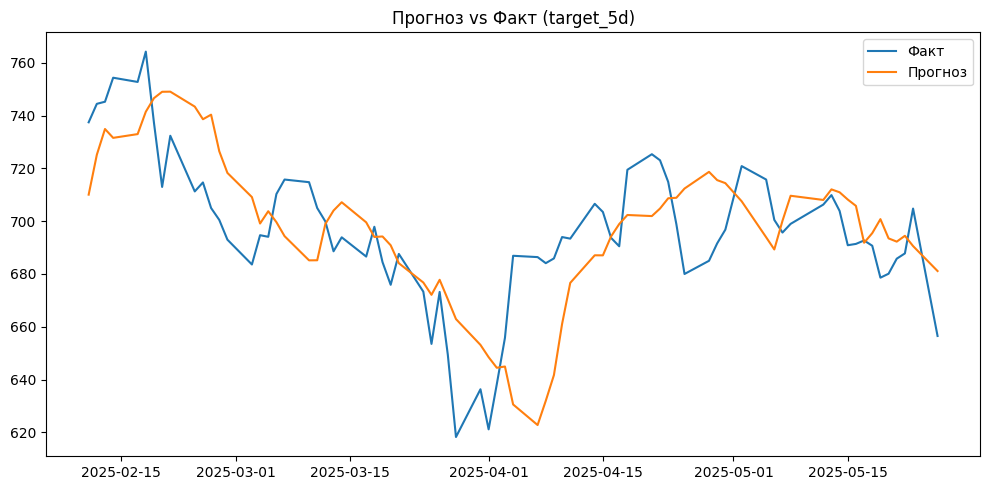

,date,fact,pred,last_price,error,abs_error,rel_error,bias
0,2025-02-11,737.5,710.072632,1.301003,27.427368,27.427368,0.037190,-27.427368
1,2025-02-12,744.5,725.195374,1.313986,19.304626,19.304626,0.025930,-19.304626
2,2025-02-13,745.3,734.959106,1.491597,10.340894,10.340894,0.013875,-10.340894
3,2025-02-14,754.4,731.602173,1.359687,22.797827,22.797827,0.030220,-22.797827
4,2025-02-17,752.8,733.027649,1.387212,19.772351,19.772351,0.026265,-19.772351


In [11]:
# Настройки
seed = 42
encoder_length = 90
batch_size = 1
target_column = "target_5d"
start_date = "2024-10-03"  # 90 дней до 2025-01-01, чтобы начать предсказание от 2025-01-01

data = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\tatn_tft_weekly_REG.csv"
ckpt = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\TFT\tft_model_target_5d.ckpt"

# Загрузка данных и модели
df_all = pd.read_csv(data, parse_dates=["date"])
model = TemporalFusionTransformer.load_from_checkpoint(ckpt)

# Приведение категориальных колонок к строкам
categorical_columns = ["group_id", "month", "day_of_week", "is_weekend"]
df_all[categorical_columns] = df_all[categorical_columns].astype(str)

# Создание шаблона TimeSeriesDataSet
training_dataset = TimeSeriesDataSet(
    df_all,
    time_idx = "time_idx",
    target = target_column,
    group_ids = ["group_id"],
    max_encoder_length = encoder_length,
    max_prediction_length = 1,
    static_categoricals = ["group_id"],
    time_varying_known_categoricals = ["month", "day_of_week", "is_weekend"],
    time_varying_known_reals = ["time_idx", "day_of_year"],
    time_varying_unknown_reals=[
        col for col in df_all.columns
        if col not in ["group_id","time_idx","date", target_column,
                       "month","day_of_week","is_weekend","day_of_year"]
    ],
    target_normalizer = GroupNormalizer(groups = ["group_id"], transformation = "softplus"),
    add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
    allow_missing_timesteps = True
)

# Подготовка df_window для скользящего прогноза
df_window = df_all[df_all["date"] >= pd.to_datetime(start_date)].reset_index(drop = True)

# Прогноз по скользящему окну
preds_all, y_true_all, last_price_all, dates = [], [], [], []
for i in range(encoder_length, len(df_window)):
    window_df = df_window.iloc[i-encoder_length : i+1].copy()
    forecast_date = window_df.iloc[-1]["date"]
    if forecast_date.year < 2025:
        continue

    dataset = TimeSeriesDataSet.from_dataset(
        training_dataset, window_df,
        predict = True, stop_randomization=True
    )
    loader = dataset.to_dataloader(train = False, batch_size = batch_size)

    pred = model.predict(loader)[0].item()
    true = window_df.iloc[-1][target_column]
    last = window_df.iloc[-2]["price"]

    print(f"{forecast_date.date()} | Прогноз: {pred:.2f} | Факт: {true:.2f}")
    preds_all.append(pred)
    y_true_all.append(true)
    last_price_all.append(last)
    dates.append(forecast_date)

# Метрики и графики
y_pred = np.array(preds_all)
y_true = np.array(y_true_all)
last_price = np.array(last_price_all)
dates = pd.to_datetime(dates)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"Оценка модели по таргету: {target_column}")
print(f"MAE:   {mae:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAPE:  {mape:.2%}")

# График распределения ошибок
errors = np.where(np.abs(y_true) < 1e-6, 0, np.abs((y_true - y_pred) / y_true))
plt.figure(figsize = (8, 4))
plt.hist(errors, bins = 20)
plt.title(f"Распределение относительных ошибок ({target_column})")
plt.xlabel("Относительная ошибка")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

# График факт vs прогноз
plt.figure(figsize=(10, 5))
plt.plot(dates, y_true, label="Факт")
plt.plot(dates, y_pred, label="Прогноз")
plt.title(f"Прогноз vs Факт ({target_column})")
plt.legend()
plt.tight_layout()
plt.show()

# Финальный DataFrame с результатами
df_results = pd.DataFrame({
    "date": dates,
    "fact": y_true,
    "pred": y_pred,
    "last_price": last_price,
    "error": y_true - y_pred,
    "abs_error": np.abs(y_true - y_pred),
    "rel_error": errors,
    "bias": y_pred - y_true
})

display(df_results.head())


#### Точечный прогноз TFT на заданную дату

В данном блоке кода мы используем обученную модель TFT для построения прогноза цены акции ПАО «Татнефть» на конкретную дату.  
Мы формируем входные данные, полностью соответствующие формату обучения, чтобы модель могла корректно спрогнозировать целевое значение.  
Это позволяет без переобучения быстро получить прогноз на любую дату, для которой доступны необходимые входные признаки.

В данном блоке мы проводим следующие операции:

1. Загрузка модели и данных — подгружаем обученную TFT и исходный ДФ с признаками.
2. Приведение категориальных признаков — переводим все категориальные колонки (`group_id`, `month`, `day_of_week`, `is_weekend`) в строковый формат, как это требуется для работы модели.
3. Определение признаков — разделяем признаки на известные наперёд (календарные) и неизвестные (ценовые и производные признаки, такие как технические индикаторы, процентные изменения цены, скользящие средние и др.), которые модель должна предсказать.
4. Выбор временного окна — берём последние 90 записей (максимальная длина энкодера), чтобы сохранить контекст временного ряда.
5. Добавление строки с будущей датой — создаём новую запись с датой прогноза, заполняем известные наперёд признаки по календарю, а неизвестные — последними доступными значениями.
6. Формирование ДФ для прогноза — с помощью `TimeSeriesDataSet` приводим данные к формату TFT, добавляем относительные индексы времени и масштабы.
7. Прогноз — загружаем подготовленные данные в `DataLoader` и получаем предсказание цены на заданную дату.
8. Оценка точности — сравниваем прогноз с фактическим значением, вычисляем абсолютную и относительную ошибки.

В результате мы получаем готовый прогноз цены акции на нужную дату, а также численную оценку ошибки, что позволяет быстро проверять точность модели в реальных условиях.

In [24]:
# Пути и параметры
ckpt = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\TFT\tft_model_target_5d.ckpt"
data = r"C:\VKR_Almaz_Mamatov\VKR_Almaz_Mamatov_DS_16\Part_3\tatn_tft_weekly_REG.csv"
d_pred = pd.to_datetime("2025-06-06")
encoder_length = 90

# Модель и данные
model = TemporalFusionTransformer.load_from_checkpoint(ckpt)
df = pd.read_csv(data, parse_dates = ["date"]).sort_values(["group_id","date"]).reset_index(drop = True)
df[["group_id","month","day_of_week","is_weekend"]] = df[["group_id","month","day_of_week","is_weekend"]].astype(str)

# Роли признаков
g, t_idx, tgt = "group_id", "time_idx", "target_5d"
known_cat = ["month","day_of_week","is_weekend"]
known_real = [t_idx, "day_of_year"]
exclude = {g, t_idx, "date", tgt, *known_cat, *known_real}
unk_real = [c for c in df.columns if c not in exclude]

# Окно последних encoder_length наблюдений по каждой группе
df_window = df.groupby(g).tail(encoder_length).copy()

# Строка будущего на d_pred (unknown-фичи - last known)
last_ti = df[t_idx].max()
future = []
for gid, grp in df_window.groupby(g):
    last = grp.iloc[-1]
    row = {
        g: gid, "date": d_pred, t_idx: last_ti + 1, tgt: 0.0,
        "month": str(d_pred.month),
        "day_of_week": str(d_pred.weekday()),
        "is_weekend": str(int(d_pred.weekday() >= 5)),
        "day_of_year": d_pred.timetuple().tm_yday,
        **{c: last[c] for c in unk_real},
    }
    future.append(row)

df_final = pd.concat([df_window, pd.DataFrame(future)], ignore_index=True)

# Шаблон и датасет для предсказания
tmpl = TimeSeriesDataSet(
    df, time_idx = t_idx, target = tgt, group_ids = [g],
    max_encoder_length = encoder_length, max_prediction_length = 1,
    static_categoricals = [g],
    time_varying_known_categoricals = known_cat,
    time_varying_known_reals = known_real,
    time_varying_unknown_reals = unk_real,
    target_normalizer = GroupNormalizer(groups = [g], transformation = "softplus"),
    add_relative_time_idx = True, add_target_scales = True, add_encoder_length = True,
    allow_missing_timesteps = True,
)

pred_ds = TimeSeriesDataSet.from_dataset(tmpl, df_final, predict = True, stop_randomization = True)
loader = pred_ds.to_dataloader(train = False, batch_size = len(future))
preds = model.predict(loader).cpu().numpy().flatten()

# Результат и краткая оценка
result = pd.DataFrame({"group_id":[r[g] for r in future], "date":[d_pred]*len(future), "prediction":preds})
print(result)

# При наличии фактической цены - оценка ошибки
real_price = 639.10  # фактическая цена на 06.06.2025
pred_price = float(preds[0])
abs_err = abs(pred_price - real_price)
rel_err = abs_err / real_price * 100
print(f"Фактическая цена:  {real_price:.2f} ₽")
print(f"Предсказание TFT: {pred_price:.2f} ₽")
print(f"Абсолютная ошибка: {abs_err:.2f} ₽")
print(f"Относительная ошибка: {rel_err:.2f} %")


C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Администратор\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Админи

  group_id       date  prediction
0  tatneft 2025-06-06  676.851379
Фактическая цена:  639.10 ₽
Предсказание TFT: 676.85 ₽
Абсолютная ошибка: 37.75 ₽
Относительная ошибка: 5.91 %
